In [124]:
import numpy as np
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.sql.types import DoubleType
from pyspark.sql.types import StringType
import re
from pyspark.sql.functions import split
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import StopWordsRemover
import pyspark.sql.functions as f
from pyspark.ml.feature import Word2Vec
import datetime
from pyspark.sql.functions import year, month, dayofmonth, dayofweek

In [123]:
# start SparkSession
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("project").getOrCreate()
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-pastel')

# 1. STORIES

In [125]:
# read in the dataset stories
data_df = spark.read\
  .format('csv')\
  .option('header', 'true')\
  .option('inferSchema', 'true')\
  .load('s3://bigdataproject233/stories.csv')

In [126]:
data_df.show()

+-------+------------+-----+------------+--------------------+--------------------+--------------------+--------------------+-------+----+-----------+------------+
|     id|          by|score|        time|             time_ts|               title|                 url|                text|deleted|dead|descendants|      author|
+-------+------------+-----+------------+--------------------+--------------------+--------------------+--------------------+-------+----+-----------+------------+
|6940813|   sarath237|  0.0|1387536270.0|2013-12-20 10:44:...| Sheryl Brindo Ho...|http://www.youtub...| Sheryl Brindo Ho...|   null|True|       null|   sarath237|
|6991401|123123321321|  0.0|1388508751.0|2013-12-31 16:52:...|Are you people al...|                null|They&#x27;re pret...|   null|True|       null|123123321321|
|1531556|         ssn|  0.0|1279617234.0|2010-07-20 09:13:...|New UI for Google...|http://googlesyst...|Again following o...|   null|null|        0.0|         ssn|
|5012398|       

In [127]:
data_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- by: string (nullable = true)
 |-- score: string (nullable = true)
 |-- time: string (nullable = true)
 |-- time_ts: string (nullable = true)
 |-- title: string (nullable = true)
 |-- url: string (nullable = true)
 |-- text: string (nullable = true)
 |-- deleted: string (nullable = true)
 |-- dead: string (nullable = true)
 |-- descendants: string (nullable = true)
 |-- author: string (nullable = true)



In [128]:
data_df.count()

2069464

In [129]:
from pyspark.sql.types import IntegerType
from pyspark.sql.types import DoubleType

story_df = data_df.select(data_df['id'].cast(IntegerType()),
                     data_df['score'].cast(IntegerType()),
                     data_df['time_ts'].cast('timestamp'),
                     data_df['title'],
                     data_df['url'],
                     data_df['text'],
                     data_df['deleted'],
                     data_df['dead'],
                     data_df['descendants'].cast(IntegerType()),
                     data_df['author']
                             )


In [130]:
story_df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- score: integer (nullable = true)
 |-- time_ts: timestamp (nullable = true)
 |-- title: string (nullable = true)
 |-- url: string (nullable = true)
 |-- text: string (nullable = true)
 |-- deleted: string (nullable = true)
 |-- dead: string (nullable = true)
 |-- descendants: integer (nullable = true)
 |-- author: string (nullable = true)



In [131]:
story_df.show(10)

+-------+-----+-------------------+--------------------+--------------------+--------------------+-------+----+-----------+------------+
|     id|score|            time_ts|               title|                 url|                text|deleted|dead|descendants|      author|
+-------+-----+-------------------+--------------------+--------------------+--------------------+-------+----+-----------+------------+
|6940813|    0|2013-12-20 10:44:30| Sheryl Brindo Ho...|http://www.youtub...| Sheryl Brindo Ho...|   null|True|       null|   sarath237|
|6991401|    0|2013-12-31 16:52:31|Are you people al...|                null|They&#x27;re pret...|   null|True|       null|123123321321|
|1531556|    0|2010-07-20 09:13:54|New UI for Google...|http://googlesyst...|Again following o...|   null|null|          0|         ssn|
|5012398|    0|2013-01-05 12:11:17|Historic website ...|http://webscrapin...|Python script to ...|   null|null|          0|        hoju|
|7214182|    0|2014-05-31 18:42:20|      

In [132]:
# create temp table
story_df.createOrReplaceTempView('ini_story')

In [133]:
story_df.select("id").distinct().count()

1959840

In [134]:
story_df.select("title").distinct().count()

1759584

In [135]:
# filter the dataset
sqlStatement = """
SELECT * 
FROM ini_story
WHERE id is not NULL 
and score is not NULL 
and time_ts is not NULL 
and title is not NULL 
and url is not NULL
and descendants is not NULL
and author is not NULL 
"""


In [136]:
clean_story_df = spark.sql(sqlStatement)
clean_story_df.count()
clean_story_df.createOrReplaceTempView('story1')

In [137]:
# get hostname of url as web

sqlStatement = """
SELECT id, score, time_ts,title,text,descendants,author,
regexp_extract(url, '([a-z]+).(com|net|co|cn|org|ru|de|br|uk|pl|ir|it|in|fr|au|jp|info|to|ca)', 1) as web
FROM story1 
"""

clean_story_df2 = spark.sql(sqlStatement)
clean_story_df2.createOrReplaceTempView('story')

In [138]:
# website information
# Where are the stories coming from? or what are the most popular sources?

sqlStatement = """
SELECT COUNT(id) AS num, web
FROM story
WHERE web != '' and web !='www'
GROUP BY web
ORDER BY num DESC
LIMIT 20
"""
web_df1 = spark.sql(sqlStatement)

In [139]:
### to be visual
# show top 10
web_df1.show(10)

+-----+-----------+
|  num|        web|
+-----+-----------+
|35467|     github|
|30490| techcrunch|
|27039|    nytimes|
|25275|   blogspot|
|24271|    youtube|
|17849|     medium|
|16503|     google|
|14321|        bbc|
|13645|arstechnica|
|13375|      wired|
+-----+-----------+
only showing top 10 rows



/home/hadoop/miniconda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


Text(0, 0.5, 'Number')

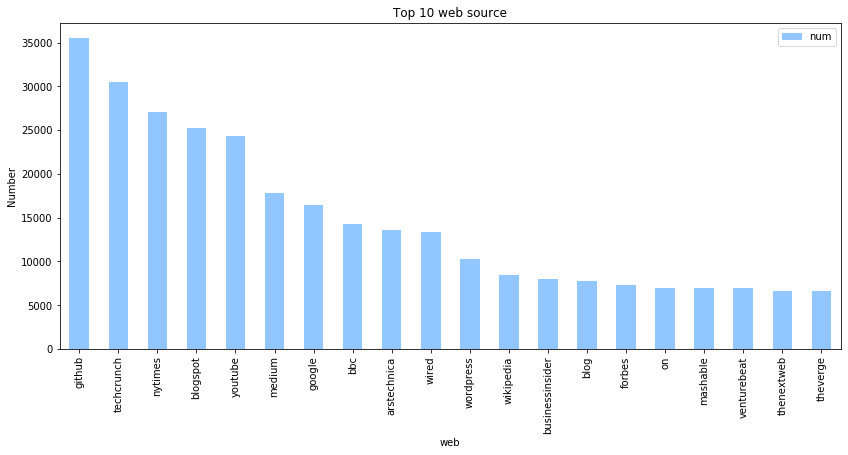

In [140]:
web_df1 = web_df1.toPandas()
web_df1.plot(x='web', y='num', 
                    kind="bar",figsize=(14,6),
                    title='Top 10 web source').set_ylabel("Number")

In [141]:
# score information
# From which website the story will have a high score in total?
sqlStatement = """
SELECT AVG(score) as avg_score, web
FROM story
WHERE web != '' and web !='www'
GROUP BY web
ORDER BY avg_score DESC
LIMIT 20
"""
web_df2 = spark.sql(sqlStatement)


In [142]:
### to be visual
# show top 10
web_df2.show(10)

+---------+--------------------+
|avg_score|                 web|
+---------+--------------------+
|   1768.0|          heartbleed|
|   1445.0|           bekkelund|
|   1323.0|          spritelamp|
|   1215.0|spotthedrowningchild|
|   1167.0|    standardmarkdown|
|   1086.0|            jeffepst|
|   1055.0|       projectnaptha|
|    925.0|     gabrielecirulli|
|    910.0|    gameaboutsquares|
|    868.0|                kfor|
+---------+--------------------+
only showing top 10 rows



Text(0, 0.5, 'Score')

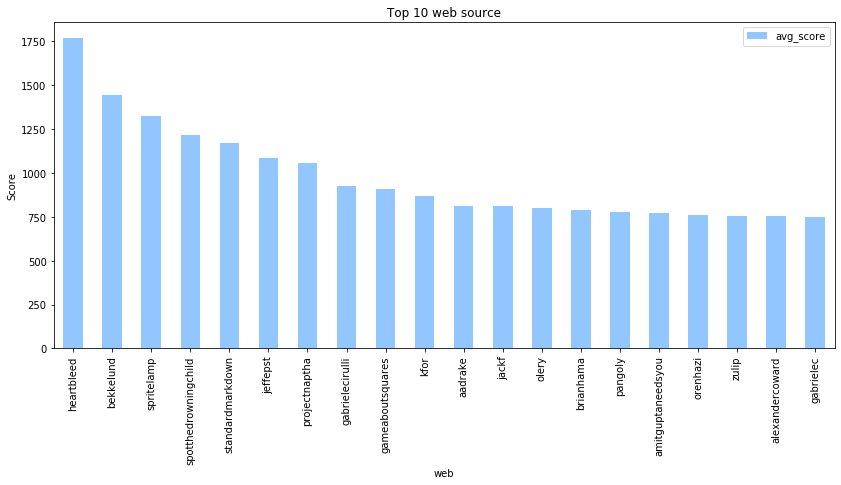

In [143]:
web_df2 = web_df2.toPandas()
web_df2.plot(x='web', y='avg_score', 
                    kind="bar",figsize=(14,6),
                    title='Top 10 web source').set_ylabel("Score")

In [144]:
# story number distribution in terms of time
# What is the trend of story numbers from 2006-2015 in Hacker News?

sqlStatement = """
SELECT COUNT(id) AS story_num, 
year(time_ts) as year
FROM story
GROUP BY year
ORDER BY year
"""
story_time_df1 = spark.sql(sqlStatement)

In [145]:
story_time_df1.show()

+---------+----+
|story_num|year|
+---------+----+
|       50|2006|
|    19761|2007|
|    64374|2008|
|   102674|2009|
|   163267|2010|
|   270554|2011|
|   292391|2012|
|   280221|2013|
|   232685|2014|
|   195259|2015|
+---------+----+



Text(0, 0.5, 'Number')

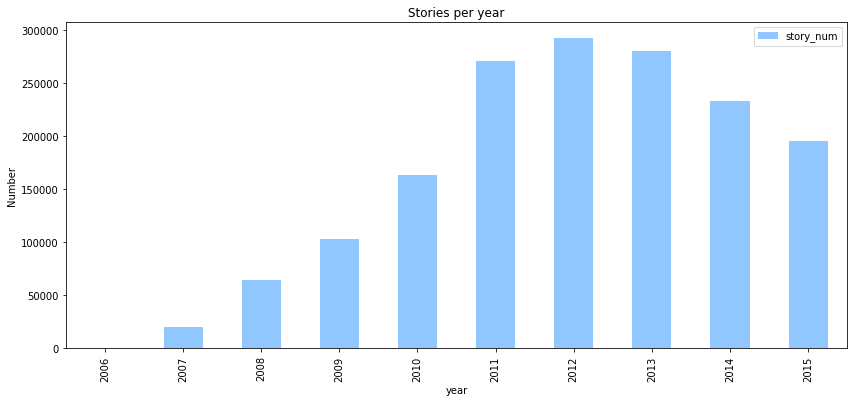

In [146]:
story_time_df1 = story_time_df1.toPandas()
story_time_df1.plot(x='year', y='story_num', 
                    kind="bar",figsize=(14,6),
                    title='Stories per year', style = 'ggplot').set_ylabel("Number")

In [147]:
# story number distribution in terms of time
# What is the most popular/active time during a day in pubulishing a story?

sqlStatement = """
SELECT COUNT(id) AS story_num, 
hour(time_ts) as hour
FROM story
GROUP BY hour
ORDER BY story_num DESC
"""
story_time_df2 = spark.sql(sqlStatement)

In [148]:
story_time_df2.show(24)

+---------+----+
|story_num|hour|
+---------+----+
|   106659|  16|
|   105078|  17|
|   103543|  15|
|    99805|  18|
|    96685|  14|
|    91096|  19|
|    85227|  20|
|    83798|  13|
|    78505|  21|
|    68565|  12|
|    67326|  22|
|    57736|  23|
|    56605|  11|
|    51692|   0|
|    49733|  10|
|    49148|   1|
|    48242|   9|
|    47439|   2|
|    46202|   3|
|    46082|   6|
|    45927|   8|
|    45546|   4|
|    45355|   7|
|    45242|   5|
+---------+----+



Text(0, 0.5, 'Number')

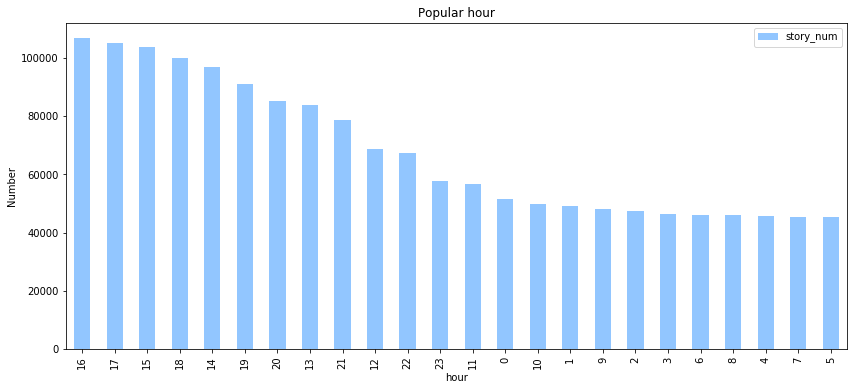

In [149]:
story_time_df2 = story_time_df2.toPandas()
story_time_df2.plot(x='hour', y='story_num', 
                    kind="bar",figsize=(14,6),
                    title='Popular hour').set_ylabel("Number")

In [150]:
# score information
# what is the average score of those story?
spark.sql("select min(score),max(score),avg(score) from story").collect()

[Row(min(score)=0, max(score)=4339, avg(score)=11.055065394550825)]

In [151]:
# author/user information 
# decending by total_score 
sqlStatement = """SELECT SUM(score) as total_score,author,
SUM(descendants) as total_decendants,
count(id) as total_stories
FROM story
GROUP BY author
ORDER BY total_score DESC
LIMIT 20
"""
user_df = spark.sql(sqlStatement)
#user_df.createOrReplaceTempView("user")

In [152]:
user_df.show(10)

+-----------+-----------+----------------+-------------+
|total_score|     author|total_decendants|total_stories|
+-----------+-----------+----------------+-------------+
|      75417|ColinWright|           29929|         3615|
|      63780| shawndumas|           25448|         6533|
|      59469|    llambda|           20136|         2580|
|      56597|      fogus|           21058|         2406|
|      53341|      danso|           22784|         2592|
|      52689|       cwan|           24061|         7058|
|      51709|        luu|           19692|         2248|
|      48935|  ssclafani|           24024|         1318|
|      41234|      evo_9|           15970|         5540|
|      41061| Libertatea|           18950|         2232|
+-----------+-----------+----------------+-------------+
only showing top 10 rows



Text(0, 0.5, 'Score')

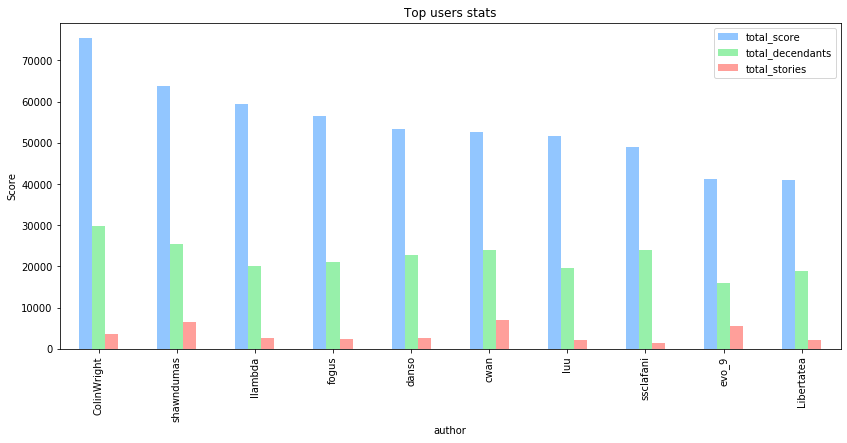

In [153]:
user_df = user_df.toPandas()
user_df.sort_values("total_score")[::-1][:10].plot(x="author",y=["total_score", "total_decendants", "total_stories"], 
                                                   kind="bar",figsize=(14,6),
                                                   title='Top users stats').set_ylabel("Score")

In [154]:
# author/user information 
# decending by total_stories 
sqlStatement = """SELECT SUM(score) as total_score, author,
SUM(descendants) as total_decendants,
count(id) as total_stories
FROM story
GROUP BY author
ORDER BY total_stories DESC
LIMIT 20
"""
user_df2 = spark.sql(sqlStatement)

In [155]:
user_df2.show(10)

+-----------+-----------+----------------+-------------+
|total_score|     author|total_decendants|total_stories|
+-----------+-----------+----------------+-------------+
|      52689|       cwan|           24061|         7058|
|      63780| shawndumas|           25448|         6533|
|      41234|      evo_9|           15970|         5540|
|      29450|      nickb|           11776|         4300|
|      26431|   iProject|           11759|         4262|
|      28334|   bootload|           11272|         4132|
|      29501|     edw519|           13577|         3809|
|      29733|     nreece|           12516|         3682|
|      75417|ColinWright|           29929|         3615|
|      36203| tokenadult|           19890|         3588|
+-----------+-----------+----------------+-------------+
only showing top 10 rows



/home/hadoop/miniconda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


Text(0, 0.5, 'Stories')

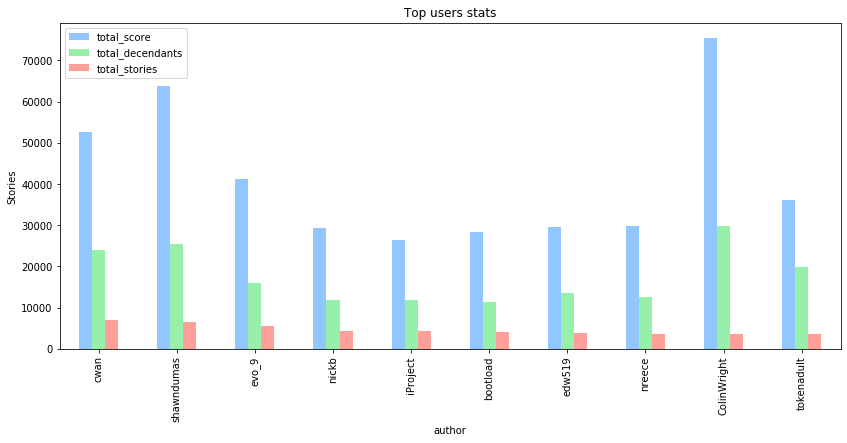

In [156]:
user_df2 = user_df2.toPandas()
user_df2.sort_values("total_stories")[::-1][:10].plot(x="author",y=["total_score", "total_decendants", "total_stories"], 
                                                   kind="bar",figsize=(14,6),
                                                   title='Top users stats').set_ylabel("Stories")

In [157]:
# author/user information 
# decending by avg_score 
sqlStatement = """SELECT SUM(score) as total_score, author,
SUM(descendants) as total_decendants, SUM(score)/count(id) as avg_score,
count(id) as total_stories
FROM story
GROUP BY author
ORDER BY avg_score DESC
LIMIT 20
"""
user_df3 = spark.sql(sqlStatement)

In [158]:
user_df3.show(10)

+-----------+---------------+----------------+---------+-------------+
|total_score|         author|total_decendants|avg_score|total_stories|
+-----------+---------------+----------------+---------+-------------+
|       1543|    realfuncode|             526|   1543.0|            1|
|       2905|     frederfred|             412|   1452.5|            2|
|       1282|          rcina|             249|   1282.0|            1|
|       1257|         kvargs|             558|   1257.0|            1|
|       1248|        mmebane|             267|   1248.0|            1|
|       1227|FlemishBeeCycle|             444|   1227.0|            1|
|       1172|     hannahmitt|             136|   1172.0|            1|
|       1125|  afraidofadria|             985|   1125.0|            1|
|       4354|   patricktomas|             385|   1088.5|            4|
|       1032|       ikeellis|             542|   1032.0|            1|
+-----------+---------------+----------------+---------+-------------+
only s

/home/hadoop/miniconda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


Text(0, 0.5, 'Score')

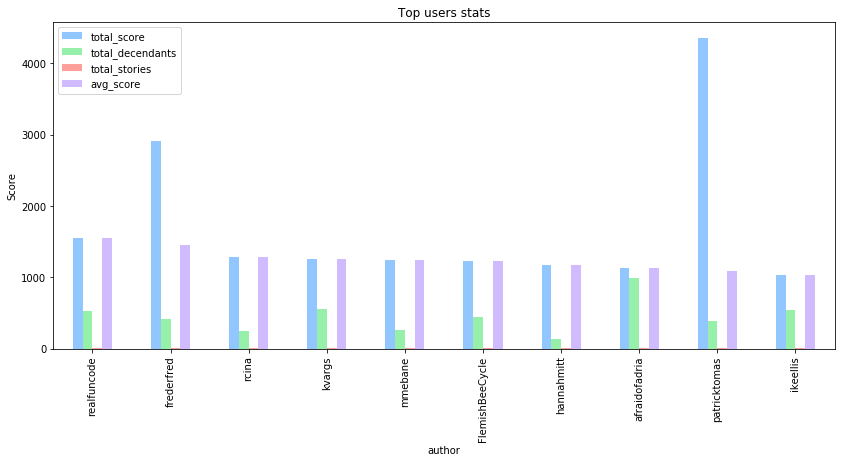

In [159]:
user_df3 = user_df3.toPandas()
user_df3.sort_values("avg_score")[::-1][:10].plot(x="author",y=["total_score", "total_decendants", "total_stories", 'avg_score'], 
                                                   kind="bar",figsize=(14,6),
                                                   title='Top users stats').set_ylabel("Score")

In [160]:
# if there is bias on YC
sqlStatement = """
SELECT score, title,id
FROM `story`
WHERE title like "%Y Combinator%" or title like "%YCombinator%" or title like "%ycombinator%" or title like "%y combinator%"
ORDER BY score  DESC
"""
YC_df = spark.sql(sqlStatement)

In [161]:
YC_df.distinct().show()

+-----+--------------------+-------+
|score|               title|     id|
+-----+--------------------+-------+
| 1065|Y Combinator is f...|5059806|
|  841|Y Combinator has ...|8033322|
|  705|Meet Watsi, Y Com...|5117385|
|  687|New: Apply to Y C...|3700712|
|  589|How I Got Kicked ...|2208155|
|  550|Benefits matter, ...|5409273|
|  549|What Happens At Y...|1733236|
|  542|How Y Combinator ...|3711008|
|  506|Y Combinator Numbers|2608440|
|  432|New Y Combinator ...|7972138|
|  425|Yuri Milner, SV A...|2154706|
|  380|Y Combinator And ...|8178450|
|  379|How I Crashed and...|8867335|
|  368|Early Photos of Y...|2942958|
|  366|Investment Firm Y...|3492711|
|  344|Y Combinator anno...|1898432|
|  342|Offer HN now at n...|1840060|
|  334|Startup developin...|7108684|
|  310|Applications open...|3515307|
|  310|TempleOS is apply...|9246855|
+-----+--------------------+-------+
only showing top 20 rows



/home/hadoop/miniconda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


Text(0, 0.5, 'Score')

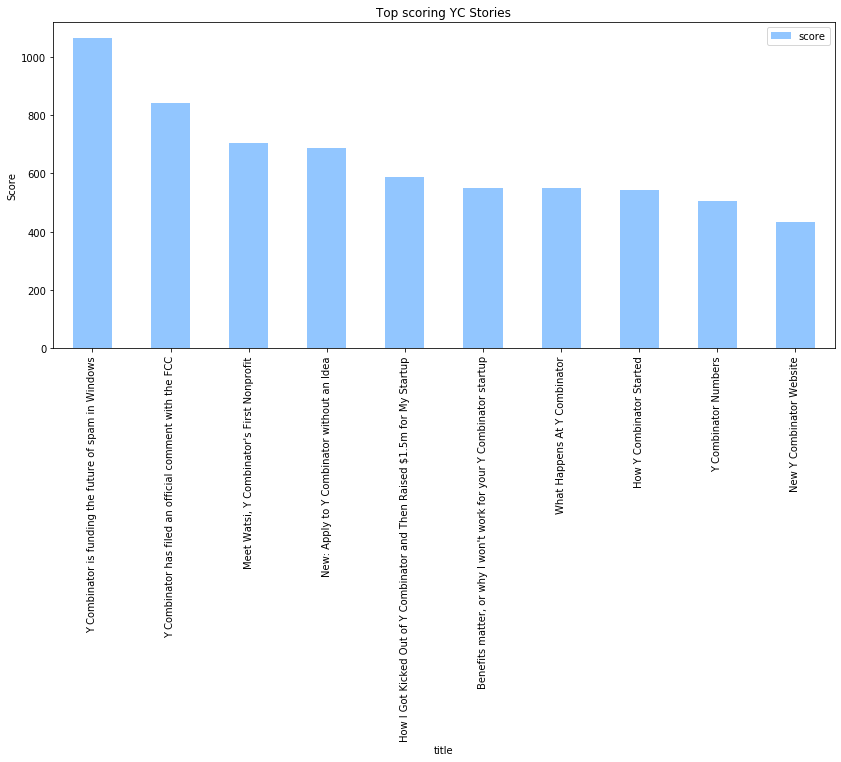

In [162]:
YC_df = YC_df.toPandas()
YC_df.sort_values("score")[::-1][:10].plot(x="title",y=["score"], 
                                                   kind="bar",figsize=(14,6),
                                                   title='Top scoring YC Stories').set_ylabel("Score")

In [163]:
# stories of major companies over the year
# apple
sqlStatement = """
SELECT count(*) as total_stories, SUM(score) as total_score,
year(time_ts) as year
FROM story
WHERE title like "%apple%" or title like "%APPLE" or title like "%Apple"
GROUP BY year
ORDER BY year
"""
Comp_df1 = spark.sql(sqlStatement)

In [164]:
Comp_df1.distinct().show()

+-------------+-----------+----+
|total_stories|total_score|year|
+-------------+-----------+----+
|            1|          7|2006|
|           27|        105|2007|
|           42|        323|2008|
|           84|        774|2009|
|          187|       1946|2010|
|          340|       5223|2011|
|          373|       4861|2012|
|          258|       2301|2013|
|          154|       2237|2014|
|          134|       3611|2015|
+-------------+-----------+----+



/home/hadoop/miniconda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


Text(0, 0.5, 'Stories')

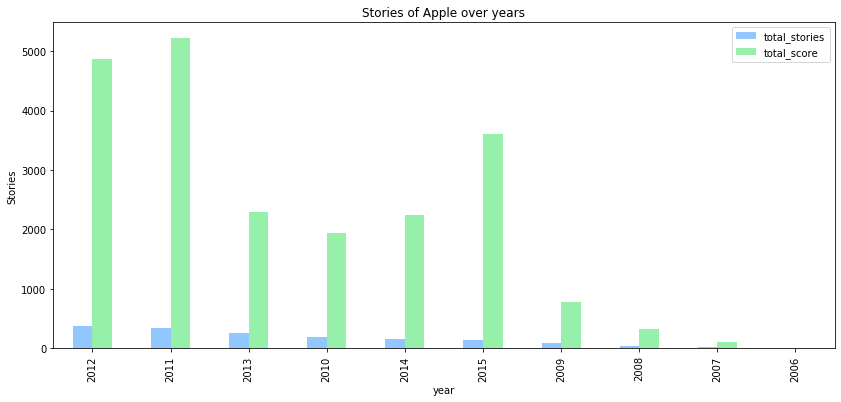

In [165]:
Comp_df1 = Comp_df1.toPandas()
Comp_df1.sort_values("total_stories")[::-1][:10].plot(x="year",y=["total_stories", 'total_score'], 
                                                   kind="bar",figsize=(14,6),
                                                   title='Stories of Apple over years').set_ylabel("Stories")

In [166]:
# stories of major companies over the year
# google
sqlStatement = """
SELECT count(*) as total_stories, SUM(score) as total_score,
year(time_ts) as year
FROM story
WHERE title like "%google%" or title like "%GOOGLE" or title like "%Google"
GROUP BY year
ORDER BY year
"""
Comp_df2 = spark.sql(sqlStatement)

In [167]:
Comp_df2.distinct().show()

+-------------+-----------+----+
|total_stories|total_score|year|
+-------------+-----------+----+
|            1|          1|2006|
|           99|        490|2007|
|          179|       1155|2008|
|          415|       3275|2009|
|          521|       6786|2010|
|          491|       8873|2011|
|          455|       7188|2012|
|          454|      10730|2013|
|          365|       7734|2014|
|          303|       9052|2015|
+-------------+-----------+----+



/home/hadoop/miniconda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


Text(0, 0.5, 'Stories')

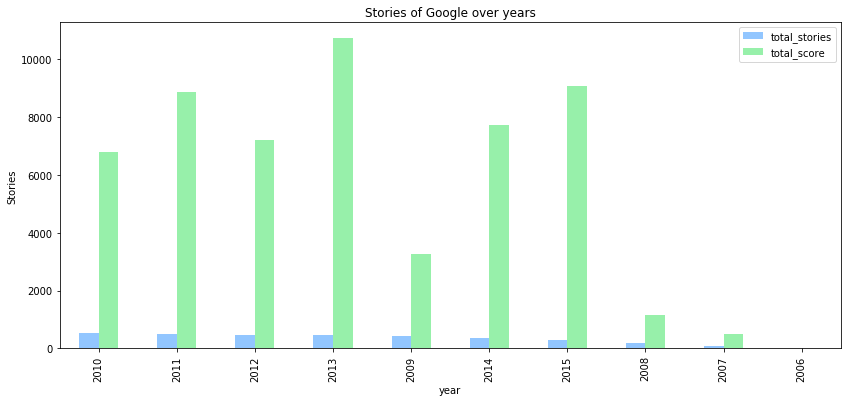

In [168]:
Comp_df2 = Comp_df2.toPandas()
Comp_df2.sort_values("total_stories")[::-1][:10].plot(x="year",y=["total_stories", 'total_score'], 
                                                   kind="bar",figsize=(14,6),
                                                   title='Stories of Google over years').set_ylabel("Stories")

In [169]:
# stories of major companies over the year
# uber
sqlStatement = """
SELECT count(*) as total_stories, SUM(score) as total_score,
year(time_ts) as year
FROM story
WHERE title like "%uber%" or title like "%UBER" or title like "%Uber"
GROUP BY year
ORDER BY year
"""
Comp_df3 = spark.sql(sqlStatement)

In [170]:
Comp_df3.distinct().show()

+-------------+-----------+----+
|total_stories|total_score|year|
+-------------+-----------+----+
|            3|          3|2007|
|           21|        196|2008|
|           22|        953|2009|
|           58|       1109|2010|
|           66|        957|2011|
|           57|        873|2012|
|           62|        518|2013|
|          215|       2697|2014|
|          267|       3240|2015|
+-------------+-----------+----+



/home/hadoop/miniconda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


Text(0, 0.5, 'Stories')

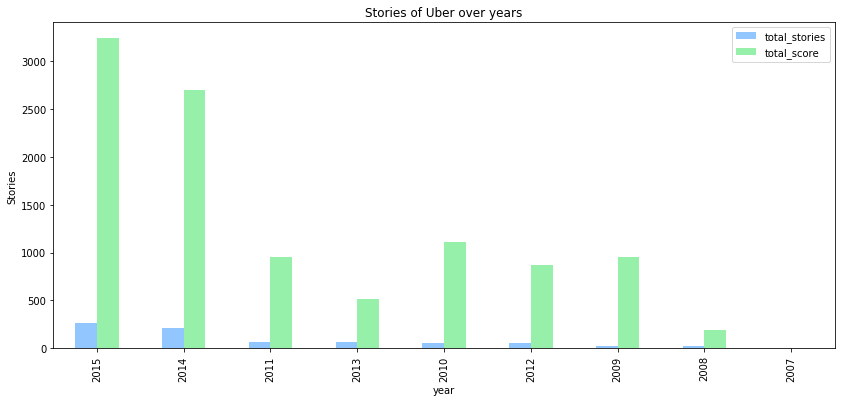

In [171]:
Comp_df3 = Comp_df3.toPandas()
Comp_df3.sort_values("total_stories")[::-1][:10].plot(x="year",y=["total_stories", 'total_score'], 
                                                   kind="bar",figsize=(14,6),
                                                   title='Stories of Uber over years').set_ylabel("Stories")

# 2. COMMENTS

In [172]:
# read in the dataset comments
data_df2 = spark.read\
  .format('csv')\
  .option('header', 'true')\
  .option('inferSchema', 'true')\
  .load('s3://chingsez/Final/comments.csv')

In [173]:
data_df2.show()

+--------------------+-------+------+----------+--------------------+--------------------+--------------------+--------------------+-------+-------+
|                  id|     by|author|      time|             time_ts|                text|              parent|             deleted|   dead|ranking|
+--------------------+-------+------+----------+--------------------+--------------------+--------------------+--------------------+-------+-------+
|             2701393|     5l|    5l|1309184881|2011-06-27 14:28:...|And the glazier w...|             2701243|                null|   null|      0|
|             5811403|     99|    99|1370234048|2013-06-03 04:34:...|Does canada have ...|             5804452|                null|   null|      0|
|               21623|     AF|    AF|1178992400|2007-05-12 17:53:...|"Speaking of Rail...|               21611|                null|   null|      0|
|            10159727|     EA|    EA|1441206574|2015-09-02 15:09:...|Humans and large ...|            1015

In [174]:
data_df2.printSchema()

root
 |-- id: string (nullable = true)
 |-- by: string (nullable = true)
 |-- author: string (nullable = true)
 |-- time: string (nullable = true)
 |-- time_ts: string (nullable = true)
 |-- text: string (nullable = true)
 |-- parent: string (nullable = true)
 |-- deleted: string (nullable = true)
 |-- dead: string (nullable = true)
 |-- ranking: string (nullable = true)



In [175]:
data_df2.count()

9796725

In [176]:
from pyspark.sql.types import IntegerType
from pyspark.sql.types import DoubleType

comment_df = data_df2.select(
                     data_df2['id'].cast(IntegerType()),                    
                     data_df2['time_ts'].cast('timestamp'),                  
                     data_df2['text'],
                     data_df2['parent'].cast(IntegerType()),
                     #data_df2['deleted'],
                     #data_df2['dead'],
                     data_df2['author'],
                     data_df2['ranking'].cast(IntegerType())

                             )

In [177]:
comment_df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- time_ts: timestamp (nullable = true)
 |-- text: string (nullable = true)
 |-- parent: integer (nullable = true)
 |-- author: string (nullable = true)
 |-- ranking: integer (nullable = true)



In [178]:
comment_df.show(10)

+--------+-------------------+--------------------+--------+------+-------+
|      id|            time_ts|                text|  parent|author|ranking|
+--------+-------------------+--------------------+--------+------+-------+
| 2701393|2011-06-27 14:28:01|And the glazier w...| 2701243|    5l|      0|
| 5811403|2013-06-03 04:34:08|Does canada have ...| 5804452|    99|      0|
|   21623|2007-05-12 17:53:20|"Speaking of Rail...|   21611|    AF|      0|
|10159727|2015-09-02 15:09:34|Humans and large ...|10159396|    EA|      0|
| 2988424|2011-09-12 18:53:00|I must say I reac...| 2988179|    Iv|      0|
| 3867418|2012-04-20 11:39:44|&#62; There's a w...| 3867404|    Iv|      0|
| 3925617|2012-05-03 20:26:05|I'm also in this ...| 3924840|    Iv|      0|
| 3107534|2011-10-13 15:34:04|how do you run un...|    null|    Iv|   null|
|    null|               null|                null|    null|  null|   null|
| 8409259|2014-10-04 11:20:47|Polio is not exte...| 8409226|    Iv|      0|
+--------+--

In [179]:
comment_df.createOrReplaceTempView('ini_comment')

In [180]:
comment_df.select("id").distinct().count()

8399564

In [181]:
clean_comment_df = spark.sql('select * from ini_comment where id is not NULL and time_ts is not NULL and text is not NULL and author is not NULL and ranking is not NULL')
clean_comment_df.createOrReplaceTempView('comment')

In [182]:
clean_comment_df.count()

6986995

In [183]:
clean_comment_df.show(10)

+--------+-------------------+--------------------+--------+------+-------+
|      id|            time_ts|                text|  parent|author|ranking|
+--------+-------------------+--------------------+--------+------+-------+
| 2701393|2011-06-27 14:28:01|And the glazier w...| 2701243|    5l|      0|
| 5811403|2013-06-03 04:34:08|Does canada have ...| 5804452|    99|      0|
|   21623|2007-05-12 17:53:20|"Speaking of Rail...|   21611|    AF|      0|
|10159727|2015-09-02 15:09:34|Humans and large ...|10159396|    EA|      0|
| 2988424|2011-09-12 18:53:00|I must say I reac...| 2988179|    Iv|      0|
| 3867418|2012-04-20 11:39:44|&#62; There's a w...| 3867404|    Iv|      0|
| 3925617|2012-05-03 20:26:05|I'm also in this ...| 3924840|    Iv|      0|
| 8409259|2014-10-04 11:20:47|Polio is not exte...| 8409226|    Iv|      0|
|   50570|2007-09-05 17:04:05|It was a risky jo...|   50556|    Jd|      0|
| 2600618|2011-05-30 22:34:14|"Looks good, ther...| 2600609|    Jd|      0|
+--------+--

In [184]:
# comment author/user information 
# who are the most contributive authors in Hacker News ?
## futhur to be done——can be joined with the most contirbutive authors in story

sqlStatement = """SELECT author,
        COUNT(id) AS total_comments
        From comment
        GROUP BY author
        ORDER BY total_comments DESC
        LIMIT 20
"""
comment_user_df = spark.sql(sqlStatement)

In [185]:
# show top 10
comment_user_df.show(10)

+------------+--------------+
|      author|total_comments|
+------------+--------------+
|     tptacek|         28605|
|    jacquesm|         19845|
|       DanBC|         10992|
|    jrockway|         10679|
|   anigbrowl|         10490|
|dragonwriter|         10203|
|         eru|          9979|
|     rbanffy|          9634|
|       sp332|          9547|
|     rayiner|          9403|
+------------+--------------+
only showing top 10 rows



/home/hadoop/miniconda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


Text(0, 0.5, 'Comments')

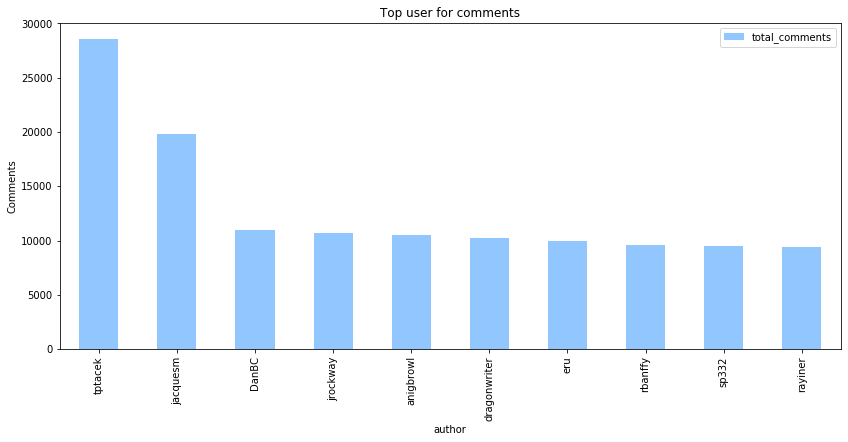

In [186]:
comment_user_df = comment_user_df.toPandas()
comment_user_df.sort_values("total_comments")[::-1][:10].plot(x="author",y='total_comments', 
                                                   kind="bar",figsize=(14,6),
                                                   title='Top user for comments').set_ylabel("Comments")

In [187]:
# comment distribution in terms of time
# What is the trend of comment numbers from 2006-2016 in Hacker News?

sqlStatement = """
SELECT COUNT(id) AS comment_num, 
year(time_ts) as year
FROM comment
GROUP BY year
ORDER BY year
"""
comment_time_df2 = spark.sql(sqlStatement)

In [188]:
comment_time_df2.show()

+-----------+----+
|comment_num|year|
+-----------+----+
|         10|2006|
|      50982|2007|
|     195678|2008|
|     382490|2009|
|     658846|2010|
|     816999|2011|
|     975306|2012|
|    1415381|2013|
|    1348324|2014|
|    1142979|2015|
+-----------+----+



/home/hadoop/miniconda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


Text(0, 0.5, 'Comments')

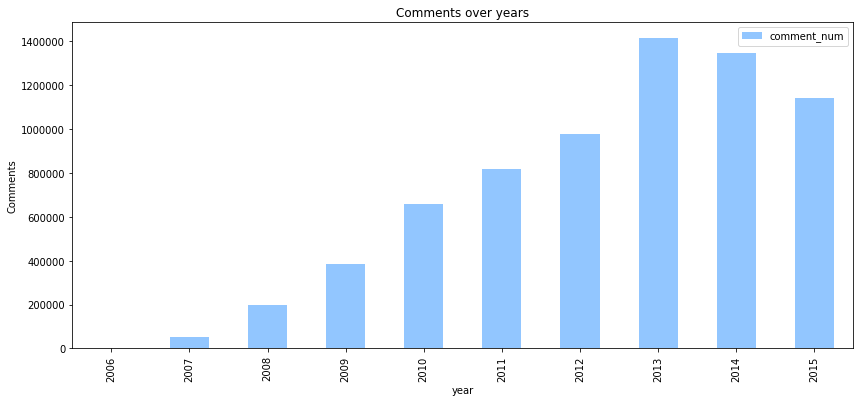

In [189]:
comment_time_df2 = comment_time_df2.toPandas()
comment_time_df2.plot(x="year",y='comment_num', 
                     kind="bar",figsize=(14,6),
                     title='Comments over years').set_ylabel("Comments")

In [190]:
# comment distribution in terms of time
# What is the most popular/active time during a day in pubulishing a comment?

sqlStatement = """
SELECT COUNT(id) AS comment_num, 
hour(time_ts) as hour
FROM comment
GROUP BY hour
ORDER BY comment_num DESC
"""
comment_time_df = spark.sql(sqlStatement)

In [191]:
comment_time_df.show(24)

+-----------+----+
|comment_num|hour|
+-----------+----+
|     451259|  17|
|     450094|  18|
|     437369|  16|
|     433640|  19|
|     421504|  20|
|     413518|  15|
|     398429|  21|
|     365798|  14|
|     353708|  22|
|     313262|  23|
|     295136|  13|
|     276703|   0|
|     251256|   1|
|     236036|   2|
|     224956|   3|
|     224367|  12|
|     210740|   4|
|     192913|   5|
|     180795|   6|
|     180141|  11|
|     172147|   7|
|     170884|   8|
|     168104|   9|
|     164236|  10|
+-----------+----+



Text(0, 0.5, 'Comments')

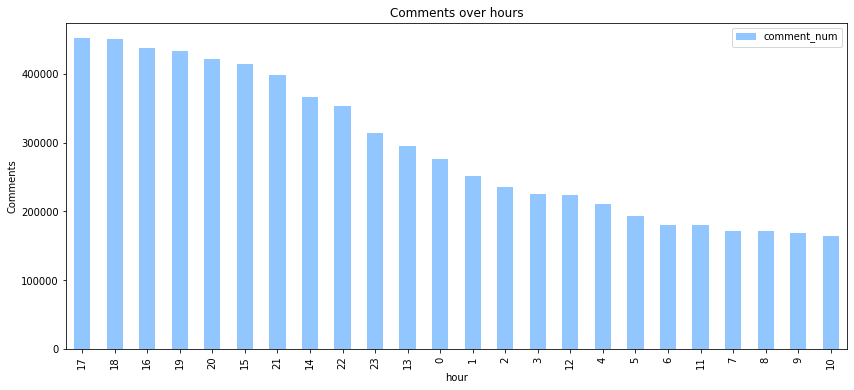

In [192]:
comment_time_df = comment_time_df.toPandas()
comment_time_df.plot(x="hour",y='comment_num', 
                     kind="bar",figsize=(14,6),
                     title='Comments over hours').set_ylabel("Comments")

In [193]:
# top(the hottest) comments with the most follow-up comment 
sqlStatement = """
SELECT COUNT(id) AS followup_num, 
parent
FROM comment
WHERE parent is not NULL
GROUP BY parent
ORDER BY followup_num DESC
LIMIT 20
"""
comment_parent_df1 = spark.sql(sqlStatement)

In [194]:
# show top 10
comment_parent_df1.show(10)

+------------+--------+
|followup_num|  parent|
+------------+--------+
|         975|     363|
|         266| 7469115|
|         266| 9996333|
|         264| 9238839|
|         262| 9812245|
|         243| 7445761|
|         241|10152809|
|         239|  752262|
|         234| 9471287|
|         228| 9303396|
+------------+--------+
only showing top 10 rows



Text(0, 0.5, 'Follow-up')

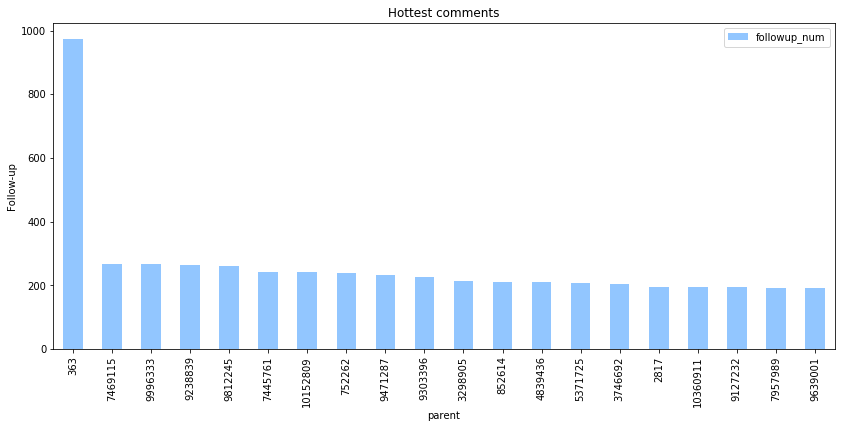

In [195]:
comment_parent_df1 = comment_parent_df1.toPandas()
comment_parent_df1.plot(x="parent",y='followup_num', 
                     kind="bar",figsize=(14,6),
                     title='Hottest comments').set_ylabel("Follow-up")

In [196]:
# ranking information
# what is the average ranking of those comments?

spark.sql("select min(ranking),max(ranking),avg(ranking) from comment").collect()

[Row(min(ranking)=-1051, max(ranking)=1131019295, avg(ranking)=58481.1891668736)]

In [122]:
spark.stop()

# Feature Engineering

### First we want to extract the 'day of week', 'year', 'month' information from the 'time_ts' column

In [197]:
story = clean_story_df.withColumn('year', year('time_ts'))
story = story.withColumn('month', month('time_ts'))
story = story.withColumn('dayofweek', dayofweek('time_ts'))

In [198]:
story.show()

+-------+-----+-------------------+--------------------+--------------------+--------------------+-------+----+-----------+------------+----+-----+---------+
|     id|score|            time_ts|               title|                 url|                text|deleted|dead|descendants|      author|year|month|dayofweek|
+-------+-----+-------------------+--------------------+--------------------+--------------------+-------+----+-----------+------------+----+-----+---------+
|1531556|    0|2010-07-20 09:13:54|New UI for Google...|http://googlesyst...|Again following o...|   null|null|          0|         ssn|2010|    7|        3|
|5012398|    0|2013-01-05 12:11:17|Historic website ...|http://webscrapin...|Python script to ...|   null|null|          0|        hoju|2013|    1|        7|
|2606988|    0|2011-06-01 12:36:11|Kidney Transplant...|http://dhshahzad....|I started indepen...|   null|True|          0|       ramis|2011|    6|        4|
|4542754|    0|2012-09-19 08:57:49|Bouncing Marble f

### Then we want to make a new column to see whether an author is one of the most active users.

In [199]:
sqlStatement = """
SELECT author, COUNT(author) AS num
FROM story1
GROUP BY author
ORDER BY num DESC
LIMIT 3000
"""
active_user = spark.sql(sqlStatement)
active_user.show()

+-------------+----+
|       author| num|
+-------------+----+
|         cwan|7058|
|   shawndumas|6533|
|        evo_9|5540|
|        nickb|4300|
|     iProject|4262|
|     bootload|4132|
|       edw519|3809|
|       nreece|3682|
|  ColinWright|3615|
|   tokenadult|3588|
|      Garbage|3508|
|         robg|3091|
|DanielRibeiro|2815|
|       Anon84|2741|
|        danso|2592|
|      llambda|2580|
|      jonbaer|2416|
|        fogus|2406|
|   transburgh|2345|
|         wslh|2268|
+-------------+----+
only showing top 20 rows



In [200]:
user = np.array(active_user.select('author').collect())

In [201]:
# Defining a function to map our column 
@udf(StringType())
def is_active_user(username):
    if username in user:
        return '1'
    return '0' 

In [202]:
story = story.withColumn('active_user', is_active_user('author'))

### Then we want to make a variable showing the information about title length

In [203]:
story = story.withColumn('title_length', f.size(f.split(f.col('title'), ' ')))

### Then we want to see whether an url is from the top domain

In [204]:
sqlStatement = """
SELECT COUNT(id) AS num, web
FROM story
WHERE web != '' and web != 'www'
GROUP BY web
ORDER BY num DESC
LIMIT 50
"""
url_df2 = spark.sql(sqlStatement)

In [205]:
# Defining a function so that we can use to map our column
hot_domain = np.array(url_df2.select('web').collect())
@udf(StringType())
def from_hot_domain(url):
    pattern = re.compile('([a-z]+).(com|net|co|cn|org|ru|de|br|uk|pl|ir|it|in|fr|au|jp|info)')
    result = re.findall(pattern, url)
    if result and result[0] in hot_domain:
        return '1'
    return '0' 

In [206]:
story = story.withColumn('from_top_web', from_hot_domain('url'))

### Just as we make a column to see whether the length of title have influence for our target, we can also extract the length of text information

In [207]:
story = story.withColumn('text_length', f.size(f.split(f.col('text'), ' ')))

In [208]:
# Since there exist empty values in our dataset, we can deal with this data by filling the column with 0
@udf(IntegerType())
def transfer(num):
    if num == -1:
        return 0 
    return num
story = story.withColumn('text_length', transfer('text_length'))

### To see whether the words in title will influence this article's score, we decided to make a new column about hot words this title use

In [209]:
# First Let's transform our title 
regexTokenizer = RegexTokenizer(inputCol="title", outputCol="words", pattern="\s+")
regexTokenized = regexTokenizer.transform(story)
regexTokenized.select("title", "words").show()

+--------------------+--------------------+
|               title|               words|
+--------------------+--------------------+
|New UI for Google...|[new, ui, for, go...|
|Historic website ...|[historic, websit...|
|Kidney Transplant...|[kidney, transpla...|
|Bouncing Marble f...|[bouncing, marble...|
|Cooking your own ...|[cooking, your, o...|
|Why You Should Re...|[why, you, should...|
|My developer tool...|[my, developer, t...|
|      Feelspace belt|   [feelspace, belt]|
|      What is Magic?|  [what, is, magic?]|
|Personal Organize...|[personal, organi...|
|Ultimate Guide of...|[ultimate, guide,...|
|       Mens t-shirts|    [mens, t-shirts]|
|  Gümrük Müşavirliği|[gümrük, müşavirl...|
|The Rule of 72: H...|[the, rule, of, 7...|
|Web Design Jobs –...|[web, design, job...|
|The A View from t...|[the, a, view, fr...|
|           Sex toys |         [sex, toys]|
|        Bespoke Suit|     [bespoke, suit]|
|Web 2.0: Browse A...|[web, 2.0:, brows...|
|Dev Vilas Resort ...|[dev, vila

In [210]:
# We don't want these stop words to be in our word list, so we use the StopWordsRemover to filter those stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
filtered = remover.transform(regexTokenized)

In [211]:
word_count = filtered.withColumn('word', f.explode(f.col('filtered')))\
    .groupBy('word')\
    .count()\
    .sort('count', ascending=False)

In [212]:
# We choose the top 300 words as the hot words
word_list = word_count.limit(300)
hot_words = np.array(word_list.select('word').collect())

In [213]:
# Defining a function to filter those words including numerical characters
def filter_words(array):
    words_list = []
    pattern = re.compile('[a-z]+')
    for word in array:
        result = re.findall(pattern, word[0])
        if result != []:
            words_list.append(result[0])
    return words_list

In [214]:
hot_word = filter_words(hot_words)

In [215]:
# Defining a function so that we can get how many hot words each title includes
@udf(IntegerType())
def count_hot_words(title):
    words = title.split(' ')
    count = 0
    for word in words:
        if word in hot_word:
            count += 1 
    return count 

In [216]:
story = story.withColumn('title_hot_words', count_hot_words('title'))

### Final step: Let's transform our title to be a word vector

In [217]:
regexTokenizer = RegexTokenizer(inputCol="title", outputCol="title_array", pattern="\s+")
regexTokenized = regexTokenizer.transform(story)

In [218]:
word2Vec = Word2Vec(vectorSize=300, minCount=5, seed = 18, inputCol="title_array", outputCol="title_vec")
model = word2Vec.fit(regexTokenized)
story_final = model.transform(regexTokenized)

In [219]:
story_final.show(5)

+-------+-----+-------------------+--------------------+--------------------+--------------------+-------+----+-----------+------+----+-----+---------+-----------+------------+------------+-----------+---------------+--------------------+--------------------+
|     id|score|            time_ts|               title|                 url|                text|deleted|dead|descendants|author|year|month|dayofweek|active_user|title_length|from_top_web|text_length|title_hot_words|         title_array|           title_vec|
+-------+-----+-------------------+--------------------+--------------------+--------------------+-------+----+-----------+------+----+-----+---------+-----------+------------+------------+-----------+---------------+--------------------+--------------------+
|1531556|    0|2010-07-20 09:13:54|New UI for Google...|http://googlesyst...|Again following o...|   null|null|          0|   ssn|2010|    7|        3|          0|           6|           1|          5|              0|[ne

In [223]:
data = story_final.select([c for c in story_final.columns if c not in ['id', 'time_ts', 'title', 'url', 'text', 'deleted', 'dead']])

In [224]:
data.show(5)

+-----+-----------+------+----+-----+---------+-----------+------------+------------+-----------+---------------+--------------------+--------------------+
|score|descendants|author|year|month|dayofweek|active_user|title_length|from_top_web|text_length|title_hot_words|         title_array|           title_vec|
+-----+-----------+------+----+-----+---------+-----------+------------+------------+-----------+---------------+--------------------+--------------------+
|    0|          0|   ssn|2010|    7|        3|          0|           6|           1|          5|              0|[new, ui, for, go...|[-0.0506976541752...|
|    0|          0|  hoju|2013|    1|        7|          0|           3|           0|          9|              1|[historic, websit...|[-0.0290550414162...|
|    0|          0| ramis|2011|    6|        4|          0|           5|           1|         79|              0|[kidney, transpla...|[0.14976164475083...|
|    0|          0| tette|2012|    9|        4|          0|     

In [226]:
data.printSchema()

root
 |-- score: integer (nullable = true)
 |-- descendants: integer (nullable = true)
 |-- author: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- dayofweek: integer (nullable = true)
 |-- active_user: string (nullable = true)
 |-- title_length: integer (nullable = false)
 |-- from_top_web: string (nullable = true)
 |-- text_length: integer (nullable = true)
 |-- title_hot_words: integer (nullable = true)
 |-- title_array: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- title_vec: vector (nullable = true)



### linear regression model

In [314]:
#Change data type
change = data.withColumn('active_user', f.col('active_user').cast('double'))
change = change.withColumn('from_top_web', f.col('from_top_web').cast('double'))
change = change.withColumn('title_vec', convert("title_vec"))

In [315]:
#Get a correlation matrix for numerical variables
from pyspark.ml.feature import VectorAssembler
from pyspark.mllib.stat import Statistics
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline
cols = ['score', 'descendants', 'year', 'dayofweek', 'month', 'text_length', 'title_hot_words', 'title_vec', 'active_user', 'from_top_web']
assemble = VectorAssembler(inputCols=cols,
                           outputCol='feat')
#Normailize features
norm = StandardScaler(
    inputCol= 'feat'
    , outputCol='normed'
    , withMean=True
    , withStd=True
)

pipeline = Pipeline(
    stages=[
        assemble
        , norm
    ])

vector = pipeline.fit(change).transform(change).select('normed')
matrix = Correlation.corr(vector, 'normed')
#实测 Normalize 与否对 correlation matrix 影响不大

In [305]:
#Spark 有 bug直接 collect 会报错，下面两行是解决报错的
#Ref:https://www.cnblogs.com/bonelee/p/10976253.html
matrix.sql_ctx.sparkSession._jsparkSession = spark._jsparkSession
matrix._sc = spark._sc
corrmatrix = matrix.collect()[0][0].toArray().tolist()

In [306]:
import pandas as pd
corr_df = pd.DataFrame(corrmatrix)
corr_df.index, corr_df.columns = cols, cols
corr_df

,score,descendants,year,dayofweek,month,text_length,title_hot_words,title_vec,active_user,from_top_web
score,1.000000,0.008808,0.049505,-0.007856,-0.001137,-0.036419,0.005488,0.014795,-0.001895,0.011461
descendants,0.008808,1.000000,0.000111,0.000832,-0.000591,0.001905,-0.000309,-0.000460,-0.000715,-0.000218
year,0.049505,0.000111,1.000000,-0.008611,-0.140630,-0.102557,0.034602,-0.044286,-0.134108,0.061733
dayofweek,-0.007856,0.000832,-0.008611,1.000000,-0.006231,0.014633,-0.000560,0.008564,-0.000535,0.000444
month,-0.001137,-0.000591,-0.140630,-0.006231,1.000000,0.002194,-0.007511,0.008402,-0.010431,-0.000185
text_length,-0.036419,0.001905,-0.102557,0.014633,0.002194,1.000000,-0.034018,0.089523,-0.085354,-0.067538
title_hot_words,0.005488,-0.000309,0.034602,-0.000560,-0.007511,-0.034018,1.000000,-0.074584,-0.033832,0.028547
title_vec,0.014795,-0.000460,-0.044286,0.008564,0.008402,0.089523,-0.074584,1.000000,-0.038902,-0.052820
active_user,-0.001895,-0.000715,-0.134108,-0.000535,-0.010431,-0.085354,-0.033832,-0.038902,1.000000,0.056899
from_top_web,0.011461,-0.000218,0.061733,0.000444,-0.000185,-0.067538,0.028547,-0.052820,0.056899,1.000000


In [348]:
# #这个是 normalize 了 features 的
# #import pyspark.ml.regression as rg
# Scale numeric variables first 

# lin_cols = ['descendants', 'year', 'dayofweek', 'month', 'text_length', 'title_hot_words', 'title_vec']
# scale_feat = VectorAssembler(inputCols=lin_cols
#     , outputCol="norm")

# features = VectorAssembler(inputCols=['normed']
#     , outputCol="features")

# norm = StandardScaler(inputCol='norm',
#                     outputCol='normed')

# score_feat = VectorAssembler(inputCols=['score']
#     , outputCol="score_feat")

# score_norm = StandardScaler(inputCol='score_feat',
#                     outputCol='score_normed')

# pipeline = Pipeline(
#     stages=[
#         scale_feat
#         , score_feat
#         , score_norm
#         , norm
#         , features
#     ])

# lr_feat = pipeline.fit(change).transform(change)

In [342]:
import pyspark.ml.regression as rg

lin_cols = ['descendants', 'year', 'dayofweek', 'month', 'text_length', 'title_hot_words', 'title_vec']


features = VectorAssembler(inputCols=lin_cols
    , outputCol="features")


lr_feat = features.transform(change)

In [343]:
import numpy as np
from pyspark.sql.types import FloatType
lr_feat.printSchema()

splitted_data = lr_feat.randomSplit([0.8, 0.2], 24)
train = splitted_data[0]
test = splitted_data[1]
print(train.count())
print(test.count())

root
 |-- score: integer (nullable = true)
 |-- descendants: integer (nullable = true)
 |-- author: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- dayofweek: integer (nullable = true)
 |-- active_user: double (nullable = true)
 |-- title_length: integer (nullable = false)
 |-- from_top_web: double (nullable = true)
 |-- text_length: integer (nullable = true)
 |-- title_hot_words: integer (nullable = true)
 |-- title_array: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- title_vec: float (nullable = true)
 |-- features: vector (nullable = true)

1297546
323690


In [317]:
# #Normalize feature
# import numpy as np
# from pyspark.sql.functions import udf
# from pyspark.sql.types import FloatType
# convert = udf(lambda x: float(np.max(x)), FloatType())
# lr_feat =  lr_feat.withColumn('score_normed', convert("score_normed"))
# lr_feat.printSchema()

# splitted_data = lr_feat.randomSplit([0.8, 0.2], 24)
# train = splitted_data[0]
# test = splitted_data[1]
# print(train.count())
# print(test.count())

root
 |-- score: integer (nullable = true)
 |-- descendants: integer (nullable = true)
 |-- author: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- dayofweek: integer (nullable = true)
 |-- active_user: double (nullable = true)
 |-- title_length: integer (nullable = false)
 |-- from_top_web: double (nullable = true)
 |-- text_length: integer (nullable = true)
 |-- title_hot_words: integer (nullable = true)
 |-- title_array: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- title_vec: float (nullable = true)
 |-- norm: vector (nullable = true)
 |-- score_feat: vector (nullable = true)
 |-- score_normed: float (nullable = true)
 |-- normed: vector (nullable = true)
 |-- features: vector (nullable = true)

1297546
323690


In [344]:
#Fit linear regression model
lr_obj = rg.LinearRegression(
    maxIter=10
    , regParam=0.01
    , elasticNetParam=1.00
    , labelCol = 'score')
lr_model =  lr_obj.fit(train)

In [345]:
summary = lr_model.summary

print(
    summary.r2
    , summary.rootMeanSquaredError
    , summary.meanAbsoluteError
)

0.003978375241408538 42.468015455888825 15.666362759987644


In [347]:
#Predict and evaluate model
lr_predictions = lr_model.transform(test)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="score",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

R Squared (R2) on test data = 0.00411987


### Cluster

In [336]:
import pyspark.ml.clustering as clust

vectorAssembler = VectorAssembler(
    inputCols= cols
    , outputCol='features')

kmeans_obj = clust.KMeans(k=5, seed=666)

kmeans_data = vectorAssembler.transform(change)

In [337]:
#Split data
splitted_data = kmeans_data.randomSplit([0.8, 0.2], 24)
train = splitted_data[0]
test = splitted_data[1]
print(train.count())
print(test.count())

1297546
323690


In [338]:
#Get kmeans result
results = (
    kmeans_obj
    .fit(train)
    .transform(test)
    .select('features', 'prediction')
)

results.show(5)

+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[0.0,-1.0,2010.0,...|         0|
|[0.0,-1.0,2012.0,...|         0|
|[0.0,0.0,2013.0,5...|         0|
|(10,[2,3,4,5,7],[...|         0|
|[0.0,0.0,2010.0,3...|         0|
+--------------------+----------+
only showing top 5 rows



In [339]:
#Evaluate kmeans model performance
from pyspark.ml.evaluation import ClusteringEvaluator
clustering_ev = ClusteringEvaluator()
clustering_ev.evaluate(results)

0.9302286150642675

In [349]:
#Get cluster center data
model = kmeans_obj.fit(train)
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[7.81605921e-01 2.01202503e+03 3.99599197e+00 6.43786259e+00
 2.25298370e+00 4.14685984e-01 1.78932334e-01]
[2.37210300e+06 2.01100000e+03 6.00000000e+00 4.00000000e+00
 3.70000000e+01 0.00000000e+00 1.35180503e-01]
[4.75011623e+01 2.01225278e+03 3.94917075e+00 6.46150691e+00
 3.32499853e-01 4.61604579e-01 1.78952945e-01]
[3.15227549e+02 2.01329733e+03 3.92779126e+00 6.30885922e+00
 3.24635922e-01 3.85315534e-01 1.95425644e-01]
[1.30577198e+02 2.01286668e+03 3.96572532e+00 6.37155041e+00
 2.82967254e-01 4.25134765e-01 1.83759983e-01]
